In [1]:
# !pip install scikeras
# !pip install hyperas
# !conda install tensorflow-gpu

# Import libraries

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("colorblind")

import tensorflow as tf
from tensorflow	import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from scikeras.wrappers import KerasRegressor, KerasClassifier

from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import StandardScaler
# from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.model_selection import RepeatedKFold, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from tensorflow.keras.models import load_model

import pickle

import os

In [53]:
dtypes_dict = {
    'Serial No.' : int,
    'GRE Score' : int,
    'TOEFL Score' : int,
    'University Rating' : int,
    'SOP' : float,
    'LOR' : float,
    'CGPA' : float,
    'Research' : int,
    'Chance of Admit ' : float
}
# memory_map = True can lead to mixed inference of data types, therefore pass one extra argument of the dtypes
admissions_data = pd.read_csv("data/admissions_data.csv", usecols=['CGPA','GRE Score', 'SOP', 'Research', 'Chance of Admit '], 
                              encoding='utf-8', dtype=dtypes_dict, memory_map=True, low_memory=True)
admissions_data.sample(5)

GRE Score  SOP  CGPA  Research  Chance of Admit 
455        305  1.5  7.64         0              0.59
247        311  2.5  8.48         0              0.71
147        326  3.0  9.11         1              0.83
114        311  3.5  8.45         1              0.59
193        336  4.5  9.53         1              0.94

In [54]:
admissions_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   GRE Score         500 non-null    int64  
 1   SOP               500 non-null    float64
 2   CGPA              500 non-null    float64
 3   Research          500 non-null    int64  
 4   Chance of Admit   500 non-null    float64
dtypes: float64(3), int64(2)
memory usage: 19.7 KB


# Preparation of the data
## Split into train and test data
- Features = all columns except for the first one which is the index and the last one

- Labels = the probability of admission

In [55]:
features = admissions_data.iloc[:, :-1]
labels = admissions_data.iloc[:, -1]

## Normalise data before feeding to the model
Among the data points there is a different scale (e.g., `GRE Score` vs `LOR`), which will create a problem when fitting the model since the features will affect unequally the outcome.

In [56]:
# Select numerical features
numerical_features = features.select_dtypes(include=['int', 'float']).columns

# Initialize ColumnTransformer
ct = ColumnTransformer([("only numeric", PowerTransformer(), numerical_features)],
                       remainder='passthrough')

# Split data
features_train, features_test, labels_train, labels_test = train_test_split(features, labels,
                                                                            test_size=0.3, random_state=42)

# Fit and transform with ColumnTransformer
features_train_scaled = ct.fit_transform(features_train)
features_test_scaled = ct.transform(features_test)

# Neural Network model
## Model's architecture

The model architecture described uses a sequential approach with a series of dense layers interspersed with dropout and batch normalization for regularization and normalization purposes, respectively. Here’s a breakdown of the architecture:

- **Number of Layers**: The model consists of 4 dense layers.
- **Number of Neurons**: Each dense layer has `units` neurons, where `units` is a parameter passed to the function `design_model_dropout`.

**Architecture:**
- Input Layer:
  - Input shape is determined by `features_train_scaled.shape[1]`.
- Hidden Layers:
  - First Dense Layer: `units` neurons, ReLU activation.
  - Dropout Layer: Dropout rate specified by `dropout_rate`.
  - Batch Normalization Layer.
  - Second Dense Layer: `units` neurons, ReLU activation.
  - Dropout Layer: Dropout rate specified by `dropout_rate`.
  - Batch Normalization Layer.
  - Third Dense Layer: `units` neurons, ReLU activation.
  - Dropout Layer: Dropout rate specified by `dropout_rate`.
  - Batch Normalization Layer.
- Output Layer:
  - Dense Layer with 1 neuron and sigmoid activation (for binary classification).
  
**Compilation and Optimization:**
- Loss Function: Mean Squared Error (`mse`).
- Metrics: Mean Absolute Error (`mae`).
- Optimizer: Adam optimizer with learning rate specified by `learning_rate`.

This architecture aims to prevent overfitting through the use of dropout and improve convergence speed via batch normalization, while the choice of Adam optimizer with a specified learning rate facilitates efficient optimization during training.

## Training and testing the model with hyper-parameter tuning

- `EarlyStopping` = it stops training when monitored metric has stopped improving
- `BatchNormalization()` = internally maintains an exponential moving average of the batch-wise mean and variance of the data
- `Drouput()` = randomly sets input units to 0 with a frequency of `rate` at each step during training time, which helps prevent overfitting. 

In [62]:
def design_model_dropout(learning_rate, units, dropout_rate):
    model = Sequential(name="log_reg_nn")
    input_ = tf.keras.Input(shape=(features_train_scaled.shape[1],))
    model.add(input_)
    model.add(layers.Dense(units, activation='relu'))
    model.add(layers.Dropout(dropout_rate)) # https://keras.io/api/layers/regularization_layers/dropout/
    model.add(layers.BatchNormalization()) # https://keras.io/api/layers/normalization_layers/batch_normalization/
    model.add(layers.Dense(units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(units, activation='relu'))
    model.add(layers.Dropout(dropout_rate))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(1, activation='sigmoid')) # arbitrary value between 0 and 1, thus only sigmoid
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(loss='mse', metrics=['mae'], optimizer=opt)
    return model

# wrap Keras model for use with sklearn GridSearchCV
model = KerasRegressor(model=design_model_dropout, verbose=0)

In [9]:
%%time

# define parameter grid for GridSearchCV
param_grid = {
    "model__units": [64, 128, 256],
    "model__learning_rate": np.arange(0.002, 0.011, 0.002),
    "model__dropout_rate": np.around(np.arange(0.0, 0.6, 0.1), decimals=2),
    "batch_size": [32, 64, 128]
}

# using RepeatedKFold for iterated k-fold validation
rkf = RepeatedKFold(n_splits=5, n_repeats=3, random_state=42)

# gridSearchCV setup
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           cv=rkf, verbose=1, n_jobs=-1, scoring='neg_mean_absolute_error')

# fit GridSearchCV to the scaled training data
grid_result = grid_search.fit(features_train_scaled, labels_train)

Fitting 15 folds for each of 270 candidates, totalling 4050 fits


2024-06-26 16:57:46.241392: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 16:57:46.272008: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 16:57:46.311577: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-26 16:57:46.312362: I tensorflow/core/platform/cpu_featu

CPU times: user 30 s, sys: 5.99 s, total: 36 s
Wall time: 32min 6s


In [64]:
# print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

# Save results in a DataFrame for plotting later
# results_df = pd.DataFrame(grid_result.cv_results_)

# Save results to a CSV file (optional)
# os.makedirs("results/", exist_ok=True) # create results directory only if it doesn't exist
# results_df.to_csv('results/grid_search_results.csv', index=False)

In [73]:
best_params = grid_result.best_params_ # save the best parameters

# access through the best parameters individually the hyperparameters
best_units = best_params.get('model__units')  # number of neurons
best_lr = best_params.get('model__learning_rate')
best_dropout_rate = best_params.get('model__dropout_rate')
best_batch = best_params.get('batch_size')

best_model = design_model_dropout(best_lr, best_units, best_dropout_rate)

# instantiate early stopping to reduce training time if highest performance reached
early_stopping = EarlyStopping(
    monitor='val_loss',
    verbose=1,  
    patience=40,
    restore_best_weights=True,
    mode='auto',
)

history = best_model.fit(
    features_train_scaled,
    labels_train,
    verbose=0,
    epochs=500,
    batch_size=best_batch,
    validation_split=0.2,
    callbacks=[early_stopping],
)

# save the model
os.makedirs("results/model/", exist_ok=True)
best_model.save('best_log_reg_nn.keras')


y_pred = best_model.predict(features_test_scaled)

print(f"y_pred shape: {y_pred.shape}")
print(f"labels_test shape: {labels_test.shape}")

# flatten y_pred if necessary
if y_pred.shape != labels_test.shape:
    y_pred = y_pred.reshape(-1)

# ensure y_pred and labels_test are the same shape
assert y_pred.shape == labels_test.shape, "Shape mismatch between predictions and actual labels after reshaping"

# calculate the R-squared value
r2 = r2_score(labels_test, y_pred)
print(f"R-squared value: {r2}")

Epoch 95: early stopping
Restoring model weights from the end of the best epoch: 55.
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
y_pred shape: (150, 1)
labels_test shape: (150,)
R-squared value: 0.8189111747676695


## Performance of the model
The results indicate that the model training process stopped early at epoch 95 due to early stopping criteria being met, with model weights restored from the end of the best epoch, which was epoch 55. This approach suggests that the model performance was optimal around epoch 55 based on the validation criteria used (likely validation loss or another metric). The prediction phase followed, showing predictions (`y_pred`) for 150 samples with a shape of (150, 1), and the actual labels (`labels_test`) also for 150 samples with a shape of (150,). The coefficient of determination (R-squared value) for the predictions compared to the actual labels is 0.819, indicating that the model explains approximately 81.9% of the variance in the test data, which suggests a reasonably good fit of the model to the test set.

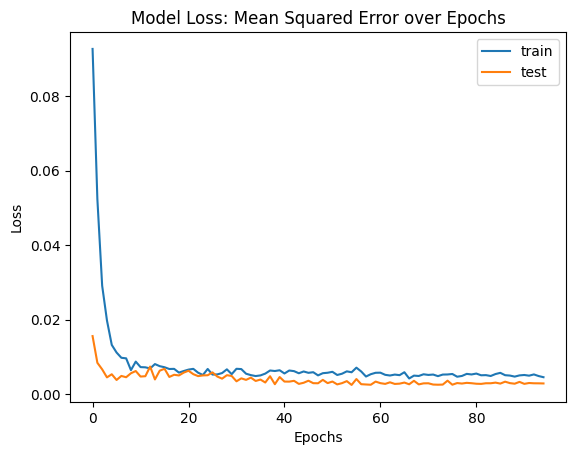

In [76]:
os.makedirs("results/plots/", exist_ok=True)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss: Mean Squared Error over Epochs')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.savefig("results/plots/mse_epochs_learn_curve.png", dpi=500, format='png')
plt.show()

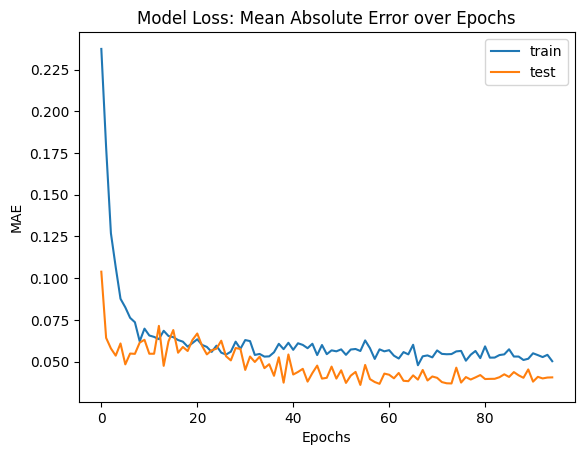

In [77]:
os.makedirs("results/plots/", exist_ok=True)

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Loss: Mean Absolute Error over Epochs')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.savefig("results/plots/mae_epochs_learn_curve.png", format='png', dpi=500)
plt.show()

In [78]:
os.makedirs("results/history", exist_ok=True)
with open('results/history/trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

print(history.history.keys())

dict_keys(['loss', 'mae', 'val_loss', 'val_mae'])


In [79]:
# in case you want to read it and do something with that
# with open('results/history/trainHistoryDict', "rb") as file_pi:
#     history = pickle.load(file_pi)